In [1]:
# Imports
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import os, json
import pandas as pd
import nltk
import sys
import requests
from bs4 import BeautifulSoup
import torch
from nltk.corpus import reuters
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string, re
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, balanced_accuracy_score 
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from flair.embeddings import FlairEmbeddings,ELMoEmbeddings ,BertEmbeddings, WordEmbeddings
from flair.embeddings import DocumentPoolEmbeddings, FastTextEmbeddings ,Sentence, XLNetEmbeddings
from sentence_transformers import SentenceTransformer

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
def clean_text(text: str, rm_numbers=True, rm_punct=True, rm_stop_words=True, rm_short_words=True):
    """ Function to perform common NLP pre-processing tasks. """

    # make lowercase
    text = text.lower()
    # remove punctuation
    if rm_punct:
        text = text.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
    # remove numbers
    if rm_numbers:
        text = re.sub(r'\d+', '', text)
    # remove whitespaces
    text = text.strip()
    # remove stopwords
    if rm_stop_words:
        stop_words = set(stopwords.words('english'))
        word_tokens = word_tokenize(text)
        text_list = [w for w in word_tokens if not w in stop_words]
        text = ' '.join(text_list)
    # remove short words
    if rm_short_words:
        text_list = [w for w in text.split() if len(w) >= 3]
        text = ' '.join(text_list)
    return text

def arxiv_dataset(path, label):
    json_files = [pos_json for pos_json in os.listdir(path) if pos_json.endswith('.txt')]
    train_data = []
    doc = {}
    for fil in json_files:
        #Reading the Json file 
        filename = path+fil
        #print(filename)
        with open(filename, 'r', encoding = 'utf-8') as file:
            data = json.load(file)            
            train_label = label
            train_text = data['text']
            doc['text'] = clean_text(train_text)
            doc['label'] = train_label
            train_data.append(doc)
            doc = {}
    print('Data Loaded')
    return train_data

In [3]:
# Calling the reuters dataset functions
train_file_path = '/opt/notebooks/datasets/arxiv_full_text/arxiv_full_data/'
test_file_path_bio = '/opt/notebooks/datasets/arxiv_full_text/arxiv_full_data_test/'
test_file_path_eess = '/opt/notebooks/datasets/arxiv_full_text/arxiv_full_data_test_eess/'
train_data_full = arxiv_dataset(train_file_path, 'notnovel')
test_data_bio = arxiv_dataset(test_file_path_bio, 'novelbio')
test_data_eess = arxiv_dataset(test_file_path_eess, 'noveleess')
train_data = train_data_full[:4000]
test_data = test_data_bio+ train_data_full[4000:]

Data Loaded
Data Loaded
Data Loaded


In [4]:
# Converting the train and test data into dataframe
train_data_df = pd.DataFrame(train_data, columns = ['text' , 'label'])
test_data_df = pd.DataFrame(test_data, columns = ['text' , 'label'])
print(train_data_df['label'].value_counts())
print(test_data_df['label'].value_counts())

notnovel    4000
Name: label, dtype: int64
notnovel    1008
novelbio     939
Name: label, dtype: int64


In [35]:
test_data_df.isna().sum()

text         0
label        0
new_label    0
dtype: int64

In [5]:
print(train_data_df['label'].value_counts())

notnovel    4000
Name: label, dtype: int64


In [6]:
def data_for_sota():                    
    # Numerical Labeling - 1 for normal class; -1 for anomaly class                    
    train_data_df['new_label'] = train_data_df['label']
    train_data_df.loc[train_data_df['label'] == 'notnovel', 'new_label'] = 1
    train_data_df.loc[train_data_df['label'] != 'notnovel', 'new_label'] = -1
    test_data_df['new_label'] = test_data_df['label']
    test_data_df.loc[test_data_df['label'] == 'notnovel', 'new_label'] = 1
    test_data_df.loc[test_data_df['label'] != 'notnovel', 'new_label'] = -1
    # Preparing train data with only normal class
    # Preparing train data with only normal class
    final_train = train_data_df
    print(final_train['new_label'].value_counts())
    # Test data with both normal and other classes
    final_test = test_data_df
    print(final_test['new_label'].value_counts())
    return final_train, final_test

In [32]:
final_train, final_test = data_for_sota()

1    4000
Name: new_label, dtype: int64
 1    1008
-1     939
Name: new_label, dtype: int64


Various Embeddings - Bert, Universal Sentence Encoder, Infersent, GloVe, Fasttext, Ensemble Embeddings(Flair + GloVe)

In [8]:
# Embedding using Universal Sentence Encoder
def embed_module(module):
    with tf.Graph().as_default():
        sentences = tf.placeholder(tf.string)
        embed = hub.Module(module)
        embeddings = embed(sentences)
        session = tf.train.MonitoredSession()
    return lambda x: session.run(embeddings, {sentences: x})

def use_embeddings():
    train_data_list = []
    test_data_list = []
    module_url = "/opt/notebooks/embedding_model/"
    # Import the Universal Sentence Encoder's TF Hub module
    embed = embed_module(module_url)
    train_data_list = embed(final_train['text'].tolist())
    test_data_list = embed(final_test['text'].tolist())
    return train_data_list, test_data_list

# Bert
def bert_embeddings():
    train_data_list = []
    test_data_list = []
    model = SentenceTransformer('bert-base-nli-mean-tokens')
    train_data_list = model.encode(final_train['text'].tolist())
    test_data_list = model.encode(final_test['text'].tolist())
    return train_data_list, test_data_list

# Flair - GloVe - XLNet - FastText
def other_embeddings(embd):
    sess = tf.InteractiveSession()
    train_data_list = []
    test_data_list = []
    if embd == 'glove':
        print('Starting Glove Embedding...')
        glove_embedding = WordEmbeddings('glove')
        document_embeddings = DocumentPoolEmbeddings(embeddings=[glove_embedding])
    elif embd == 'xlnet':
        print('Starting XLNet Embedding...')
        xlnet_embedding = XLNetEmbeddings('xlnet-large-cased')
        document_embeddings = DocumentPoolEmbeddings(embeddings=[xlnet_embedding])
    elif embd == 'fasttext':
        print('Starting Fasttext Embedding...')
        fasttext_embedding = FastTextEmbeddings('crawl-300d-2M')
        document_embeddings = DocumentPoolEmbeddings(embeddings=[fasttext_embedding])
    elif embd == 'elmo':
        print('Starting ELMo Embedding...')
        elmo_embedding = ELMoEmbeddings()
        document_embeddings = DocumentPoolEmbeddings(embeddings=[elmo_embedding])
    else:
        # init Flair embeddings
        flair_forward_embedding = FlairEmbeddings('multi-forward')
        flair_backward_embedding = FlairEmbeddings('multi-backward')
        glove_embedding = WordEmbeddings('glove')
        # now create the DocumentPoolEmbeddings object that combines all embeddings
        document_embeddings = DocumentPoolEmbeddings(embeddings=[glove_embedding, flair_forward_embedding, flair_backward_embedding])
    print('Train embedding Started...')
    for text in final_train['text'].tolist():
        text = Sentence(text)
        document_embeddings.embed(text)
        emb = text.get_embedding().detach().numpy()
        emb = tf.constant(emb).eval()
        train_data_list.append(emb)
    print('Embedded Train data!!')
    print('Test embedding Started...')
    for text in final_test['text'].tolist():
        text = Sentence(text)
        document_embeddings.embed(text)
        emb = text.get_embedding().detach().numpy()
        emb = tf.constant(emb).eval()
        test_data_list.append(emb)
    print('Embedded Test data!!')
    return train_data_list, test_data_list

def elmo_vectors(x):
        embeddings = elmo(x, signature="default", as_dict=True)["elmo"]
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sess.run(tf.tables_initializer())
            # return average of ELMo features
            return sess.run(tf.reduce_mean(embeddings,1))
        
def elmo_embeddings():
    train_data_list = []
    test_data_list = []
    elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
    elmo_train = [elmo_vectors(final_train['text'].tolist())]
    elmo_test = [elmo_vectors(final_test['text'].tolist())]
    for i in range(len(final_train['text'].tolist())):
        train_data_list.append(elmo_train[0][i])
    for i in range(len(final_test['text'].tolist())):
        test_data_list.append(elmo_test[0][i])
    return train_data_list, test_data_list

def infersent_embeddings():
    train_data_list = []
    test_data_list = []
    sys.path.append('/opt/notebooks/OCSVM_ISF_LOF_USE_Baselines/InferSent-master')
    # Load model
    from models import InferSent
    model_version = 1
    MODEL_PATH = "/opt/notebooks/OCSVM_ISF_LOF_USE_Baselines/InferSent-master/encoder/infersent%s.pkl" % model_version
    params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                    'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
    model = InferSent(params_model)
    model.load_state_dict(torch.load(MODEL_PATH))
    # Keep it on CPU or put it on GPU
    use_cuda = False
    model = model.cuda() if use_cuda else model
    # If infersent1 -> use GloVe embeddings. If infersent2 -> use InferSent embeddings.
    W2V_PATH = '/opt/notebooks/OCSVM_ISF_LOF_USE_Baselines/InferSent-master/glove.840B.300d-003.txt' if model_version == 1 else '/opt/notebooks/OCSVM_ISF_LOF_USE_Baselines/InferSent-master/fastText/crawl-300d-2M.vec'
    model.set_w2v_path(W2V_PATH)
    # Load embeddings of K most frequent words
    model.build_vocab_k_words(K=100000)
    train_data_list = model.encode(final_train['text'].tolist(), bsize=128, tokenize=False, verbose=True)
    print('nb sentences encoded : {0}'.format(len(train_data_list)))
    test_data_list = model.encode(final_test['text'].tolist(), bsize=128, tokenize=False, verbose=True)
    print('nb sentences encoded : {0}'.format(len(test_data_list)))
    return train_data_list, test_data_list

In [9]:
# Specify the embeddings 'glove', 'xlnet', 'fasttext', 'elmo', 'ensemble'
train_data_list_global, test_data_list_global = use_embeddings()
#train_data_list_global, test_data_list_global = bert_embeddings()
#train_data_list_global, test_data_list_global = infersent_embeddings()
#train_data_list_global, test_data_list_global = elmo_embeddings()
#train_data_list_global, test_data_list_global = other_embeddings('glove')

I1120 11:26:02.738620 140005129237888 saver.py:1499] Saver not created because there are no variables in the graph to restore
W1120 11:26:02.921033 140005129237888 deprecation.py:323] From /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:1354: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
I1120 11:26:03.062603 140005129237888 monitored_session.py:240] Graph was finalized.
I1120 11:26:03.875415 140005129237888 session_manager.py:500] Running local_init_op.
I1120 11:26:04.846740 140005129237888 session_manager.py:502] Done running local_init_op.


In [10]:
train_data_list = train_data_list_global
test_data_list = test_data_list_global

In [11]:
# OCSVM model
def oneclass_svm(dataset, kernel, nu):
    svm = OneClassSVM(kernel=kernel, nu=nu).fit(dataset)
    return svm
  
# Isolation Forest
def isolationForest(dataset, rng):
    isolationforest = IsolationForest(behaviour='new', max_samples=100, random_state=rng, contamination='auto').fit(dataset)
    return isolationforest

def local_outlier_factory(dataset, neighbours):
    lof = LocalOutlierFactor(n_neighbors=neighbours, contamination=0.1,novelty=True).fit(dataset)
    return lof

def pca(train, test):
    print('Principal Component Analysis ...')
    ss = StandardScaler()
    ss.fit(train)
    train = ss.transform(train)
    test = ss.transform(test)
    pca = PCA()
    pca = pca.fit(train)
    print('Explained variance percentage = %0.2f' % sum(pca.explained_variance_ratio_))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    train = pca.transform(train)
    test = pca.transform(test)
    return train, test

def results(model, train_true_labels, train_predicted_labels, test_true_labels, test_predicted_labels):
    print('Model: ', model)
    print("Train accuracy:", accuracy_score(train_true_labels, train_predicted_labels))
    print("Test accuracy:", accuracy_score(test_true_labels, test_predicted_labels))
    results = confusion_matrix(test_true_labels, test_predicted_labels, [1,-1]) 
    #print('Confusion Matrix :')
    #print(results) 
    #print('Report : ')
    LABELS = ["known", "unknown"]
    plt.figure(figsize=(6, 6))
    sns.heatmap(results, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix - Reuters - " + str(model))
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print(classification_report(test_true_labels, test_predicted_labels))

Principal Component Analysis ...
Explained variance percentage = 1.00


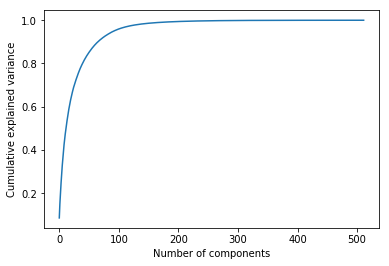

In [12]:
train_data_list, test_data_list = pca(train_data_list, test_data_list)

Model:  one Class SVM
Train accuracy: 0.8985
Test accuracy: 0.6923472008217771


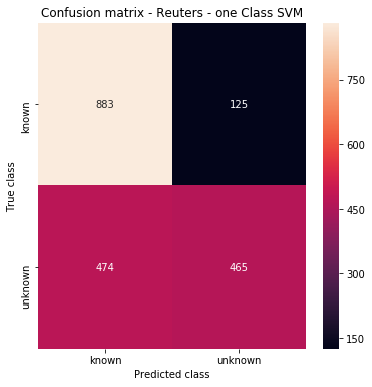

              precision    recall  f1-score   support

          -1       0.79      0.50      0.61       939
           1       0.65      0.88      0.75      1008

    accuracy                           0.69      1947
   macro avg       0.72      0.69      0.68      1947
weighted avg       0.72      0.69      0.68      1947



In [13]:
svm_model = oneclass_svm(train_data_list, 'rbf', 0.1)
y_pred_train = svm_model.predict(train_data_list)
y_pred_test = svm_model.predict(test_data_list)
results('one Class SVM', final_train['new_label'].tolist(), y_pred_train, final_test['new_label'].tolist(), y_pred_test)

Model:  Isolation Forest
Train accuracy: 0.9515
Test accuracy: 0.6307139188495121


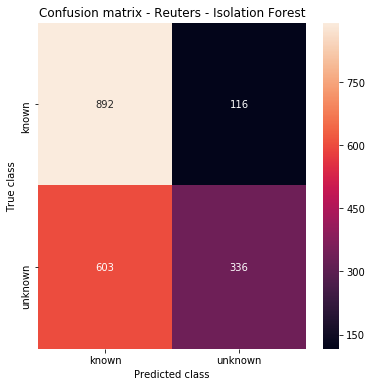

              precision    recall  f1-score   support

          -1       0.74      0.36      0.48       939
           1       0.60      0.88      0.71      1008

    accuracy                           0.63      1947
   macro avg       0.67      0.62      0.60      1947
weighted avg       0.67      0.63      0.60      1947



In [14]:
rand_state = np.random.RandomState(42)
iso_forest = isolationForest(train_data_list, rand_state)
y_pred_iso_train = iso_forest.predict(train_data_list)
y_pred_iso_test = iso_forest.predict(test_data_list)
results('Isolation Forest', final_train['new_label'].tolist(), y_pred_iso_train, final_test['new_label'].tolist(), y_pred_iso_test)

Model:  Local Outlier Factory
Train accuracy: 0.90025
Test accuracy: 0.6743708269131998


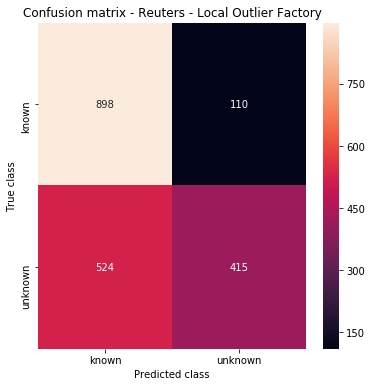

              precision    recall  f1-score   support

          -1       0.79      0.44      0.57       939
           1       0.63      0.89      0.74      1008

    accuracy                           0.67      1947
   macro avg       0.71      0.67      0.65      1947
weighted avg       0.71      0.67      0.66      1947



In [15]:
lof = local_outlier_factory(train_data_list, 1000)
y_pred_lof_train = lof.predict(train_data_list)
y_pred_lof_test = lof.predict(test_data_list)
results('Local Outlier Factory', final_train['new_label'].tolist(), y_pred_lof_train, final_test['new_label'].tolist(), y_pred_lof_test)

In [16]:
# Converting the train and test data into dataframe
train_data_df = pd.DataFrame(train_data, columns = ['text' , 'label'])
test_data_df = pd.DataFrame(test_data, columns = ['text' , 'label'])

In [17]:
def data_for_autoencoder():
    # Numerical Labeling - 0 for normal class; 1 for anomaly class                    
    train_data_df['new_label'] = train_data_df['label']
    train_data_df.loc[train_data_df['label'] == 'notnovel', 'new_label'] = 0
    train_data_df.loc[train_data_df['label'] != 'notnovel', 'new_label'] = 1
    test_data_df['new_label'] = test_data_df['label']
    test_data_df.loc[test_data_df['label'] == 'notnovel', 'new_label'] = 0
    test_data_df.loc[test_data_df['label'] != 'notnovel', 'new_label'] = 1
    # Preparing train data with only normal class
    final_train = train_data_df
    print(final_train['new_label'].value_counts())
    # Test data with both normal and other classes
    final_test = test_data_df
    print(final_test['new_label'].value_counts())
    return final_train, final_test

In [18]:
final_train, final_test = data_for_autoencoder()

0    4000
Name: new_label, dtype: int64
0    1008
1     939
Name: new_label, dtype: int64


In [26]:
# Specify the embeddings 'glove', 'xlnet', 'fasttext', 'elmo', 'ensemble'
#train_data_list, test_data_list = use_embeddings()
#train_data_list, test_data_list = bert_embeddings()
#train_data_list, test_data_list = infersent_embeddings()
#train_data_list, test_data_list = elmo_embeddings()
#train_data_list, test_data_list = other_embeddings('glove')

I1115 13:09:09.564547 140398135391616 saver.py:1499] Saver not created because there are no variables in the graph to restore
I1115 13:09:10.070795 140398135391616 monitored_session.py:240] Graph was finalized.
I1115 13:09:11.347765 140398135391616 session_manager.py:500] Running local_init_op.
I1115 13:09:12.676157 140398135391616 session_manager.py:502] Done running local_init_op.


In [19]:
X_train = train_data_list
y_train = final_train['new_label'].tolist()
X_test = test_data_list
y_test = final_test['new_label'].tolist()

In [20]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

In [21]:
input_dim = X_train.shape[1]
encoding_dim = 14
nb_epoch = 100
batch_size = 32

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)


autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model_arxiv.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs_reuters',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

W1120 11:33:35.011734 140005129237888 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W1120 11:33:35.015905 140005129237888 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/callbacks/tensorboard_v1.py:200: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W1120 11:33:35.016440 140005129237888 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/callbacks/tensorboard_v1.py:203: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Train on 4000 samples, validate on 1947 samples
Epoch 1/100
4000/4000 [==============================] - 1s 138us/step - loss: 1.0228 - accuracy: 0.0425 - val_loss: 1.2627 - val_accuracy: 0.1418


W1120 11:33:35.727126 140005129237888 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/callbacks/tensorboard_v1.py:343: The name tf.Summary is deprecated. Please use tf.compat.v1.Summary instead.



Epoch 2/100
4000/4000 [==============================] - 0s 99us/step - loss: 1.0018 - accuracy: 0.1630 - val_loss: 1.2330 - val_accuracy: 0.2686
Epoch 3/100
4000/4000 [==============================] - 0s 110us/step - loss: 0.9814 - accuracy: 0.2218 - val_loss: 1.2067 - val_accuracy: 0.3005
Epoch 4/100
4000/4000 [==============================] - 0s 100us/step - loss: 0.9659 - accuracy: 0.2482 - val_loss: 1.1842 - val_accuracy: 0.3380
Epoch 5/100
4000/4000 [==============================] - 0s 104us/step - loss: 0.9530 - accuracy: 0.2790 - val_loss: 1.1645 - val_accuracy: 0.3595
Epoch 6/100
4000/4000 [==============================] - 0s 97us/step - loss: 0.9411 - accuracy: 0.3170 - val_loss: 1.1471 - val_accuracy: 0.4032
Epoch 7/100
4000/4000 [==============================] - 0s 102us/step - loss: 0.9304 - accuracy: 0.3453 - val_loss: 1.1327 - val_accuracy: 0.3883
Epoch 8/100
4000/4000 [==============================] - 0s 105us/step - loss: 0.9215 - accuracy: 0.3645 - val_loss: 1.1

4000/4000 [==============================] - 0s 106us/step - loss: 0.8292 - accuracy: 0.5173 - val_loss: 1.0053 - val_accuracy: 0.5347
Epoch 58/100
4000/4000 [==============================] - 0s 105us/step - loss: 0.8281 - accuracy: 0.5192 - val_loss: 1.0031 - val_accuracy: 0.5285
Epoch 59/100
4000/4000 [==============================] - 0s 97us/step - loss: 0.8273 - accuracy: 0.5257 - val_loss: 0.9987 - val_accuracy: 0.5470
Epoch 60/100
4000/4000 [==============================] - 0s 97us/step - loss: 0.8259 - accuracy: 0.5250 - val_loss: 0.9958 - val_accuracy: 0.5455
Epoch 61/100
4000/4000 [==============================] - 0s 104us/step - loss: 0.8244 - accuracy: 0.5320 - val_loss: 0.9931 - val_accuracy: 0.5439
Epoch 62/100
4000/4000 [==============================] - 0s 91us/step - loss: 0.8234 - accuracy: 0.5307 - val_loss: 0.9902 - val_accuracy: 0.5485
Epoch 63/100
4000/4000 [==============================] - 0s 104us/step - loss: 0.8222 - accuracy: 0.5312 - val_loss: 0.9881 - v

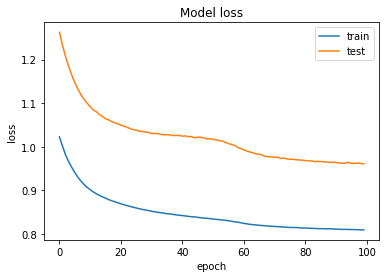

In [22]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [23]:
#Load the model for prediction
autoencoder = load_model('model_arxiv.h5')
predictions = autoencoder.predict(X_test)

mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

error_df.describe()

,reconstruction_error,true_class
count,1947.000000,1947.000000
mean,0.952684,0.482280
std,0.399830,0.499814
min,0.319838,0.000000
25%,0.669814,0.000000
50%,0.872570,0.000000
75%,1.139338,1.000000
max,5.287098,1.000000


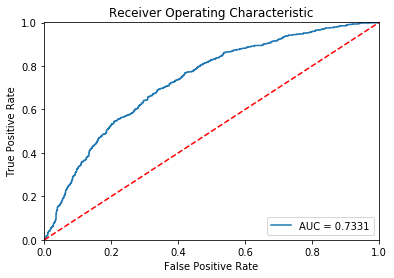

In [24]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

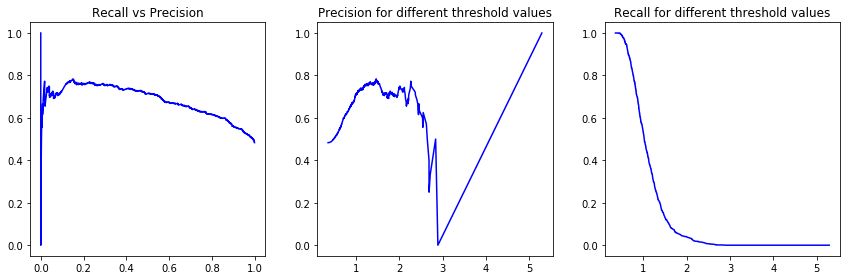

In [25]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
#plt.plot(recall, precision, 'b', label='Precision-Recall curve')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
axes[0].plot(recall, precision, 'b', label='Precision-Recall curve')
axes[0].set_title('Recall vs Precision')
axes[1].plot(th, precision[1:], 'b', label='Threshold-Precision curve')
axes[1].set_title('Precision for different threshold values')
axes[2].plot(th, recall[1:], 'b', label='Threshold-Recall curve')
axes[2].set_title('Recall for different threshold values')
fig.tight_layout()

Maximum Test accuracy: 0.6764335792890106
Threshold for maximal accuracy:  0.8661017


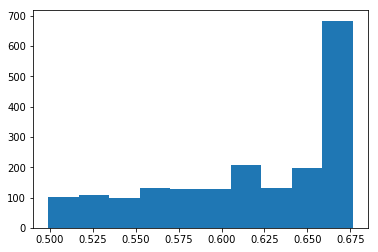

In [26]:
accuracies = []
for threshold in th:
    y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
    accuracies.append(balanced_accuracy_score(error_df.true_class, y_pred))
print("Maximum Test accuracy:", max(accuracies))
#print(accuracies.index(max(accuracies)))
print('Threshold for maximal accuracy: ', th[accuracies.index(max(accuracies))])
threshold = th[accuracies.index(max(accuracies))]
fig = plt.figure()
ax = fig.add_subplot(111)
_ = ax.hist(accuracies)

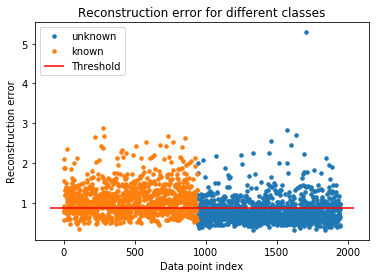

In [27]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "known" if name == 1 else "unknown")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

Test accuracy: 0.6759116589625064


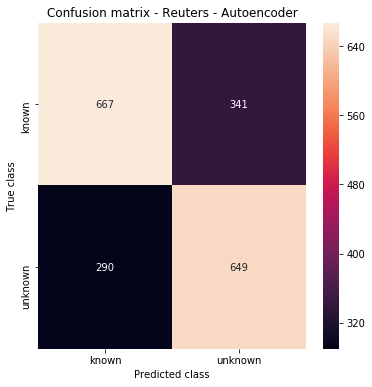

              precision    recall  f1-score   support

           0       0.70      0.66      0.68      1008
           1       0.66      0.69      0.67       939

    accuracy                           0.68      1947
   macro avg       0.68      0.68      0.68      1947
weighted avg       0.68      0.68      0.68      1947



In [28]:
LABELS = ["known", "unknown"]
y_pred_autoencoder = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred_autoencoder,[0,1])
print("Test accuracy:", accuracy_score(error_df.true_class, y_pred_autoencoder))
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix - Reuters - Autoencoder")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
print(classification_report(error_df.true_class, y_pred_autoencoder))

Base individual models end. Ensemble approaches begin from here

In [29]:
for i in range(len(y_pred_autoencoder)):
    if y_pred_autoencoder[i] == 0:
        y_pred_autoencoder[i] = 1
    else:
        y_pred_autoencoder[i] = -1
#print(y_pred_autoencoder)

Model:  Ensemble
Test accuracy: 0.689779147406266


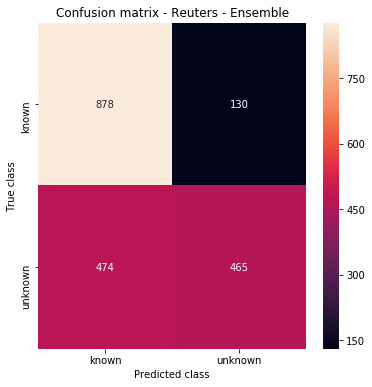

              precision    recall  f1-score   support

          -1       0.78      0.50      0.61       939
           1       0.65      0.87      0.74      1008

    accuracy                           0.69      1947
   macro avg       0.72      0.68      0.68      1947
weighted avg       0.71      0.69      0.68      1947



In [33]:
import math as mt
def mostFrequent(arr): 
    n = len(arr)
    # Insert all elements in Hash. 
    Hash = dict() 
    for i in range(n): 
        if arr[i] in Hash.keys(): 
            Hash[arr[i]] += 1
        else: 
            Hash[arr[i]] = 1
  
    # find the max frequency 
    max_count = 0
    res = -1
    for i in Hash:  
        if (max_count < Hash[i]):  
            res = i 
            max_count = Hash[i] 
          
    return res  

def ensemble_results(model, test_true_labels, test_predicted_labels):
    print('Model: ', model)
    #print("Train accuracy:", accuracy_score(train_true_labels, train_predicted_labels))
    print("Test accuracy:", accuracy_score(test_true_labels, test_predicted_labels))
    results = confusion_matrix(test_true_labels, test_predicted_labels, [1,-1]) 
    #print('Confusion Matrix :')
    #print(results) 
    #print('Report : ')
    LABELS = ["known", "unknown"]
    plt.figure(figsize=(6, 6))
    sns.heatmap(results, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix - Reuters - " + str(model))
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print(classification_report(test_true_labels, test_predicted_labels))
    
'''y_pred_train_ensemble = []
for i in range(len(final_train['new_label'].tolist())):
    train_arr = [ y_pred_train[i], y_pred_iso_train[i], y_pred_lof_train[i]]
    y_pred_train_ensemble.append(mostFrequent(train_arr))
'''
y_pred_test_ensemble = []

for i in range(len(final_test['new_label'].tolist())):
    arr = [ y_pred_test[i], y_pred_iso_test[i], y_pred_lof_test[i], y_pred_autoencoder[i]]
    y_pred_test_ensemble.append(mostFrequent(arr))

ensemble_results('Ensemble', final_test['new_label'].tolist(), y_pred_test_ensemble)